## Necessary imports and initial setup

In [1]:
from google.colab import drive
import locale
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')
def getpreferredencoding(do_setlocale=True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
# Change to the working directory
%cd drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3

Mounted at /content/drive
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3


## Getting all data

In [2]:
# Get image and label paths
img_paths = []
label_paths = []

for label in os.listdir('labels'):
    label_paths.append("labels/" + label)
for image in os.listdir('images'):
    img_paths.append("images/" + image)

img_paths = sorted(img_paths)
label_paths = sorted(label_paths)

#Visualizing Original Image

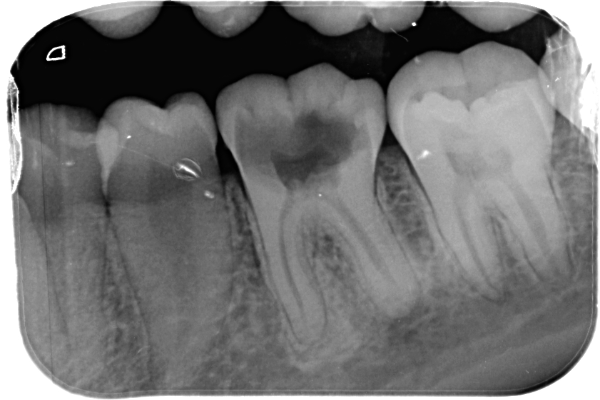

In [30]:
original_image = cv2.imread(img_paths[110])
original_image = cv2.resize(original_image, (600, 400))
cv2_imshow(original_image)


## Image Cropping
Images were cropped using the coordinates obtained from **Label Studio**.

In [3]:

def crop_image(image_path, label_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        return None, None

    # Read the label
    x_label = []
    y_label = []

    with open(label_path, 'r') as file:
        label = file.read()
    number_strings = label.split()
    label = [float(num) for num in number_strings]

    # Separate x and y coordinates
    for i in range(len(label)):
        if i % 2 == 1 and (label[i] not in [0, 1, 2, 3, 4]):
            x_label.append(label[i])
        else:
            if i != 0 and (label[i] not in [0, 1, 2, 3, 4]):
                y_label.append(label[i])

    # Convert to numpy arrays for easy manipulation
    x_label = np.array(x_label)
    y_label = np.array(y_label)

    # Find the min and max coordinates
    x_min = np.min(x_label)
    x_max = np.max(x_label)
    y_min = np.min(y_label)
    y_max = np.max(y_label)

    y_min = int(y_min * image.shape[0])
    y_max = int(y_max * image.shape[0])
    x_min = int(x_min * image.shape[1])
    x_max = int(x_max * image.shape[1])

    # Ensure coordinates are within image bounds
    y_min = max(0, y_min)
    y_max = min(image.shape[0], y_max)
    x_min = max(0, x_min)
    x_max = min(image.shape[1], x_max)

    if x_min >= x_max or y_min >= y_max:
        print(f"Invalid bounding box for image: {image_path}")
        return None, None

    # Crop the image
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

# Visualizing cropped image using semantic labels

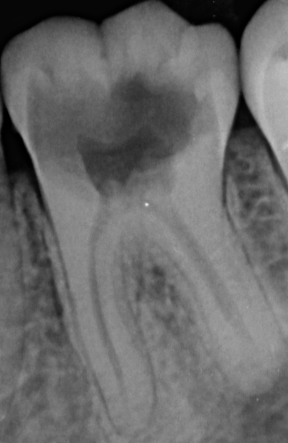

In [32]:
cropped_image = crop_image(img_paths[110], label_paths[110])

cv2_imshow(cropped_image)

## Saving all cropped images

In [ ]:
# Process all images and labels
output_folder = 'cropped_images'
processed_images = []
for img_path, lbl_path in zip(img_paths, label_paths):
    processed_image = crop_image(img_path, lbl_path)
    processed_image.append(processed_image, img_path)
    if processed_image is not None:
        # Save the processed image
        output_path = os.path.join(output_folder, os.path.basename(img_path))
        cv2.imwrite(output_path, processed_image)


# MMG Enhancement and Transperancy blending


In [4]:
def enhancement_mmg(image, mv, T, avg_pixel_value):

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define the structuring element
    B = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Apply dilation and erosion
    dilated_image = cv2.dilate(gray_image, B)
    eroded_image = cv2.erode(gray_image, B)

    # Compute the morphological gradient (DmE)
    DmE = dilated_image - eroded_image

    # Apply the Enhancement mMG Algorithm
    enhanced_image = np.zeros_like(DmE, dtype=np.float32)
    for i in range(DmE.shape[0]):
        for j in range(DmE.shape[1]):
            if DmE[i, j] >= T:
                enhanced_image[i, j] = DmE[i, j] * mv

    # Normalize the result to the range 0-255
    alpha = 0.186 + (42.85/avg_pixel_value)

    enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX)
    enhanced_image = np.uint8(enhanced_image)
    blended = cv2.addWeighted(gray_image, alpha, enhanced_image, 1-alpha, 0)

    return blended, alpha

In [18]:
from PIL import Image
import numpy as np

def average_pixel_value(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        # Convert the image to a numpy array
        img_array = np.array(img)

        # Calculate the average pixel value
        avg_pixel_value = np.mean(img_array)

    return avg_pixel_value

## Saving all preprocessed images

In [ ]:
import os
kappa = 0.20722607945068422

for img in os.listdir("cropped_images"):
  img2= img
  avg_value= average_pixel_value("cropped_images/"+img)
  img= cv2.imread("cropped_images/"+img2)
  thresh = kappa*avg_value

  alpha_kappa_image= enhancement_mmg(img, 10000 ,thresh ,avg_value)[0]
  %cd ..
  cv2.imwrite("kappa_val/images/" + img2, alpha_kappa_image)
  %cd val


/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3/val
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3/val
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3/val
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3/val
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3/val
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3/val
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3
/content/drive/MyDrive/KCDH/project-1-at-2024-06-24-09-55-560eb9b3/val
/content/drive/MyDrive/KCDH/projec

# Visualization of final preprocessed image

In [33]:
img_paths[110]

'images/330e6650-20190160295.jpg'

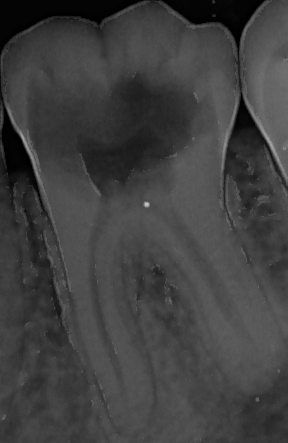

In [34]:
avg_value= average_pixel_value("cropped_images/330e6650-20190160295.jpg")
img= cv2.imread("cropped_images/330e6650-20190160295.jpg")
kappa = 0.20722607945068422
thresh = kappa*avg_value

alpha_kappa_image= enhancement_mmg(img, 10000 ,thresh ,avg_value)[0]
cv2_imshow(alpha_kappa_image)